# 1. Load Data

In [1]:
# Summaary data set

# Load data
import os
import pandas as pd
import glob
import json
import numpy as np
import seaborn as sns
import gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import BallTree
import tqdm
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Confirm the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /home/qusta100/STGNN


In [2]:
# Load data (restore from saved file)
df = pd.read_csv("/gpfs/scratch/qusta100/Gasoline/Data/Temp/final.csv")

/var/tmp/pbs.15900138.hpc-batch/ipykernel_141832/446036515.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/gpfs/scratch/qusta100/Gasoline/Data/Temp/final.csv")


In [3]:
df.head()

,date,station_uuid,diesel,e5,e10,uuid,name,brand,street,house_number,...,first_active,openingtimes_json,day,in_thuringia,last_seen,is_open,weekday,holiday,time,Brent_Price
0,2025-04-01 00:00:00,00060075-0001-4444-8888-acdc00000001,1.589,1.739,1.699,00060075-0001-4444-8888-acdc00000001,1A Tank,NaN,Schlegelstr.,13,...,2014-03-18 16:45:31+01,{},2025-04-30,True,2025-04-30 21:45:00,True,Dienstag,0,00:00,74.959999
1,2025-04-01 00:15:00,00060075-0001-4444-8888-acdc00000001,1.589,1.739,1.699,00060075-0001-4444-8888-acdc00000001,1A Tank,NaN,Schlegelstr.,13,...,2014-03-18 16:45:31+01,{},2025-04-30,True,2025-04-30 21:45:00,True,Dienstag,0,00:15,74.959999
2,2025-04-01 00:30:00,00060075-0001-4444-8888-acdc00000001,1.589,1.739,1.699,00060075-0001-4444-8888-acdc00000001,1A Tank,NaN,Schlegelstr.,13,...,2014-03-18 16:45:31+01,{},2025-04-30,True,2025-04-30 21:45:00,True,Dienstag,0,00:30,74.959999
3,2025-04-01 00:45:00,00060075-0001-4444-8888-acdc00000001,1.589,1.739,1.699,00060075-0001-4444-8888-acdc00000001,1A Tank,NaN,Schlegelstr.,13,...,2014-03-18 16:45:31+01,{},2025-04-30,True,2025-04-30 21:45:00,True,Dienstag,0,00:45,74.959999
4,2025-04-01 01:00:00,00060075-0001-4444-8888-acdc00000001,1.589,1.739,1.699,00060075-0001-4444-8888-acdc00000001,1A Tank,NaN,Schlegelstr.,13,...,2014-03-18 16:45:31+01,{},2025-04-30,True,2025-04-30 21:45:00,True,Dienstag,0,01:00,74.959999


In [4]:
# List all variables (columns)
print(df.columns.tolist())

# Print total number of observations (rows)
print(len(df))

# Print number of unique station_uuid values
print(df['station_uuid'].nunique())

['date', 'station_uuid', 'diesel', 'e5', 'e10', 'uuid', 'name', 'brand', 'street', 'house_number', 'post_code', 'city', 'latitude', 'longitude', 'first_active', 'openingtimes_json', 'day', 'in_thuringia', 'last_seen', 'is_open', 'weekday', 'holiday', 'time', 'Brent_Price']
1154251
402


# 2. Graphs

## 2.1. Average Fuel Price per Category

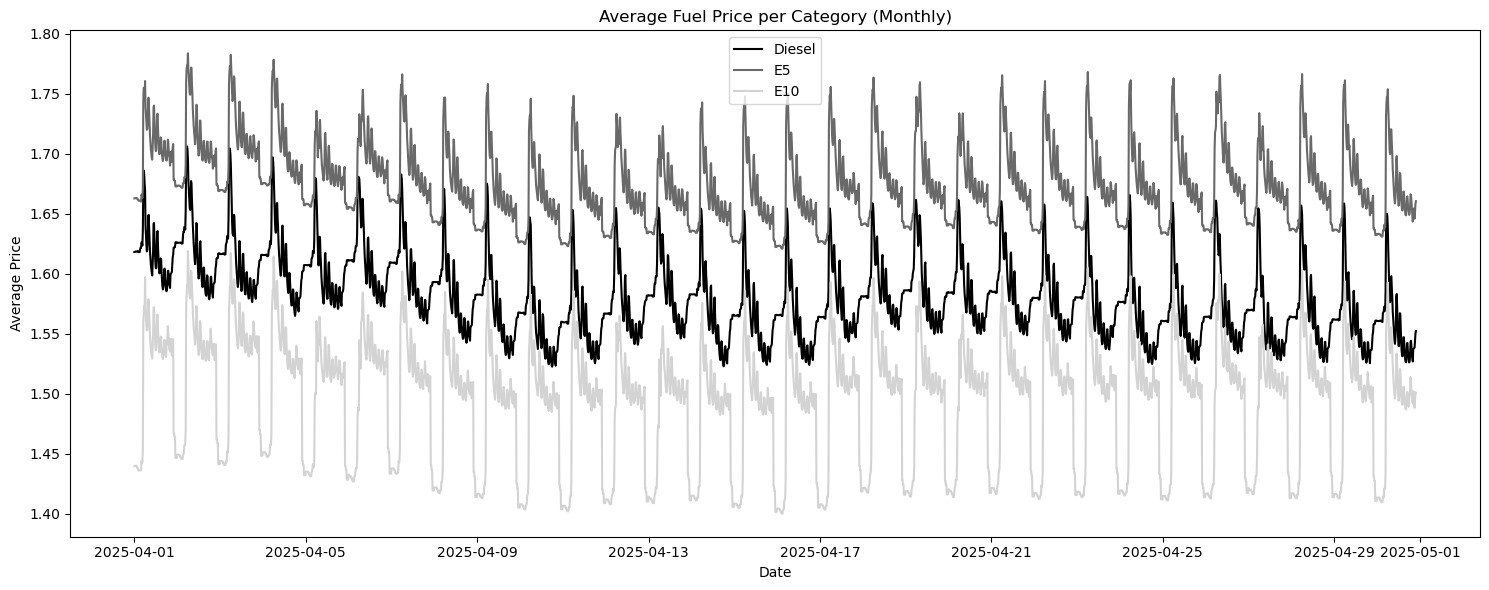

In [5]:
# Convert 'date' column to datetime if not already done
df['date'] = pd.to_datetime(df['date'])

# Group by timestamp and calculate mean prices
avg_prices = df.groupby('date')[['diesel', 'e5', 'e10']].mean()

# Create plot
plt.figure(figsize=(15, 6))
plt.plot(avg_prices.index, avg_prices['diesel'], label='Diesel', color='black')
plt.plot(avg_prices.index, avg_prices['e5'], label='E5', color='dimgray')
plt.plot(avg_prices.index, avg_prices['e10'], label='E10', color='lightgray')

plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Fuel Price per Category (Monthly)')
plt.legend()
plt.tight_layout()
plt.savefig("graphs/price_month.png")
plt.show()

## 2.2 Average Fuel Prices by Category

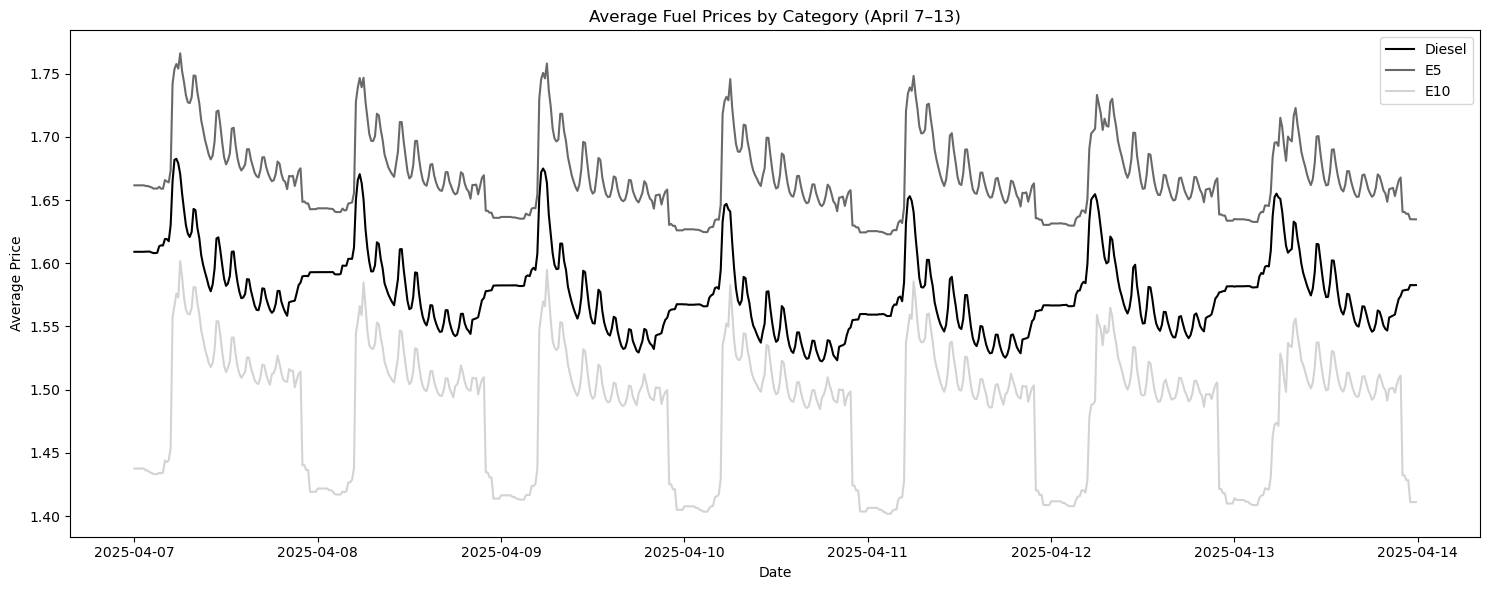

In [6]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Select time range: April 7 to April 13
start = pd.Timestamp('2025-04-07')
end = pd.Timestamp('2025-04-13 23:59:59')
mask = (df['date'] >= start) & (df['date'] <= end)
subset = df.loc[mask]

# Group by timestamp and calculate mean prices
avg_prices = subset.groupby('date')[['diesel', 'e5', 'e10']].mean()

# Plot
plt.figure(figsize=(15, 6))
plt.plot(avg_prices.index, avg_prices['diesel'], label='Diesel', color='black')
plt.plot(avg_prices.index, avg_prices['e5'], label='E5', color='dimgray')
plt.plot(avg_prices.index, avg_prices['e10'], label='E10', color='lightgray')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Fuel Prices by Category (April 7–13)')
plt.legend()
plt.tight_layout()
plt.savefig("graphs/price_week.png")
plt.show()

## 2.3 Number of Price Changes

In [7]:
# 1) Date format and sorting
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(['station_uuid', 'date'])

# 2) Calendar day
df['day'] = df['date'].dt.floor('D')

# 3) Mark Price Change per Station (True wenn Price_t != Price_t-1)
cols = ['e5', 'e10', 'diesel']

group = df.groupby('station_uuid')[cols]
shifted = group.shift()

for c in cols:
    df[f'price_changed_{c}'] = df[c].ne(shifted[c]) & df[c].notna()

# 4) Count per station and day
results = []

for f in cols:
    tmp = (
        df.groupby(['station_uuid', 'day'])[f'price_changed_{f}']
          .sum()
          .astype(int)
          .rename(f'num_price_changes_{f}')
          .reset_index()
    )
    results.append(tmp)
    
changes_per_day = results[0]
for r in results[1:]:
    changes_per_day = changes_per_day.merge(r, on=['station_uuid', 'day'])

# 5) Computation of Statistics
stats = {}
for f in cols:
    col = f'num_price_changes_{f}'
    stats[f] = {
        'avg': changes_per_day[col].mean(),
        'min': changes_per_day[col].min(),
        'max': changes_per_day[col].max()
    }

# 6) Output of Statistics
for f, v in stats.items():
    print(f"{f}: avg={v['avg']:.2f}, min={v['min']}, max={v['max']}")

e5: avg=19.05, min=0, max=47
e10: avg=17.93, min=0, max=47
diesel: avg=19.96, min=0, max=48


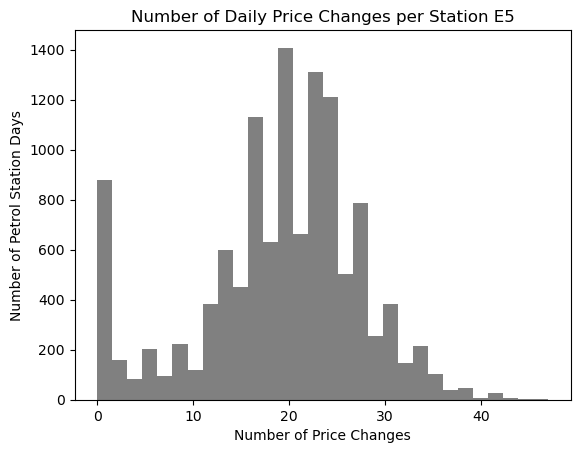

In [17]:
# Number of Price Changes, E5
plt.figure()
plt.hist(
    changes_per_day['num_price_changes_e5'],
    bins=30,
    density=False,
    color='gray'
)
plt.title("Number of Daily Price Changes per Station E5")
plt.xlabel("Number of Price Changes")
plt.ylabel("Number of Petrol Station Days")
plt.show()

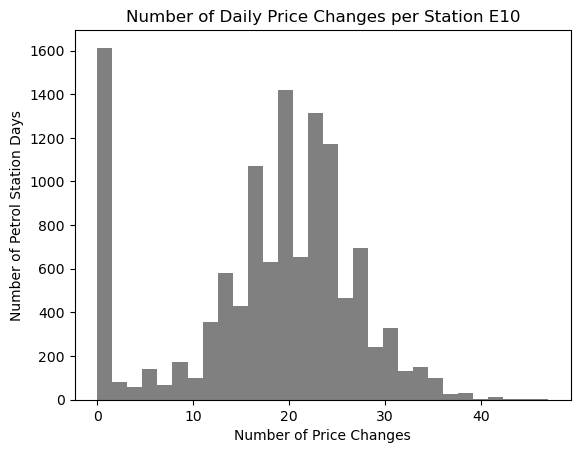

In [18]:
# Number of Price Changes, E10
plt.figure()
plt.hist(
    changes_per_day['num_price_changes_e10'],
    bins=30,
    density=False,
    color='gray'
)
plt.title("Number of Daily Price Changes per Station E10")
plt.xlabel("Number of Price Changes")
plt.ylabel("Number of Petrol Station Days")
plt.show()

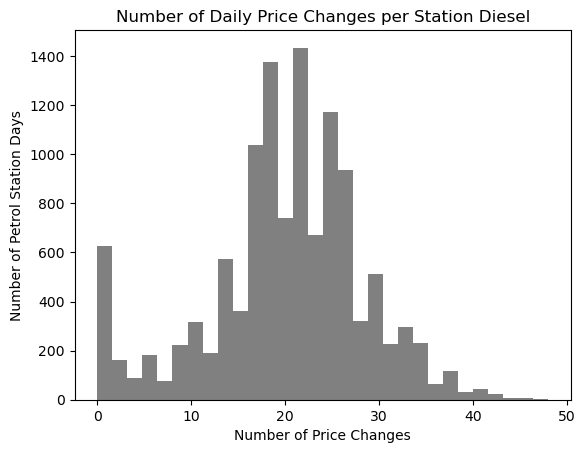

In [19]:
# Number of Price Changes, Diesel
plt.figure()
plt.hist(
    changes_per_day['num_price_changes_diesel'],
    bins=30,
    density=False,
    color='gray'
)
plt.title("Number of Daily Price Changes per Station Diesel")
plt.xlabel("Number of Price Changes")
plt.ylabel("Number of Petrol Station Days")
plt.show()

## 2.4 Time interval between price changes

In [20]:
# make sure date is datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

def compute_changes(df, flag):
    tmp = df[df[flag]]
    return (
        tmp.assign(time_since_last_change =
                   tmp.groupby('station_uuid')['date'].diff())
           .dropna(subset=['time_since_last_change'])
    )

changes_e5 = compute_changes(df, 'price_changed_e5')
changes_e10 = compute_changes(df, 'price_changed_e10')
changes_diesel = compute_changes(df, 'price_changed_diesel')

In [21]:
def add_stats(df, name):
    df['minutes_since_change'] = df['time_since_last_change'].dt.total_seconds() / 60
    avg_time = df['minutes_since_change'].mean()
    min_time = df['minutes_since_change'].min()
    max_time = df['minutes_since_change'].max()
    print(f"{name}: Avg {avg_time:.2f}, Min {min_time:.2f}, Max {max_time:.2f}")

add_stats(changes_e5, "E5")
add_stats(changes_e10, "E10")
add_stats(changes_diesel, "Diesel")

E5: Avg 72.03, Min 15.00, Max 29160.00
E10: Avg 73.13, Min 15.00, Max 29160.00
Diesel: Avg 70.64, Min 15.00, Max 39615.00


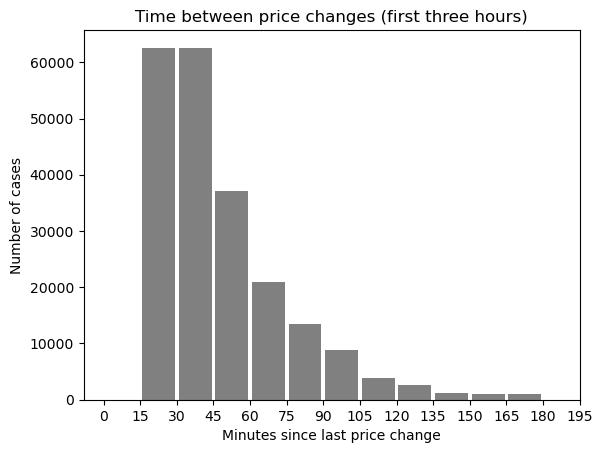

In [25]:
# Time interval between price changes, E5
mask = changes_e5['minutes_since_change'] <= 180

plt.figure()
plt.hist(
    changes_e5.loc[mask, 'minutes_since_change'],
    bins = np.arange(0, 195, 15),
    density=False,
    color='gray',
    rwidth=0.9 
)
plt.title("Time between price changes (first three hours)")
plt.xlabel("Minutes since last price change")
plt.ylabel("Number of cases")
xticks = range(0, 201, 15)
plt.xticks(xticks)
plt.show()

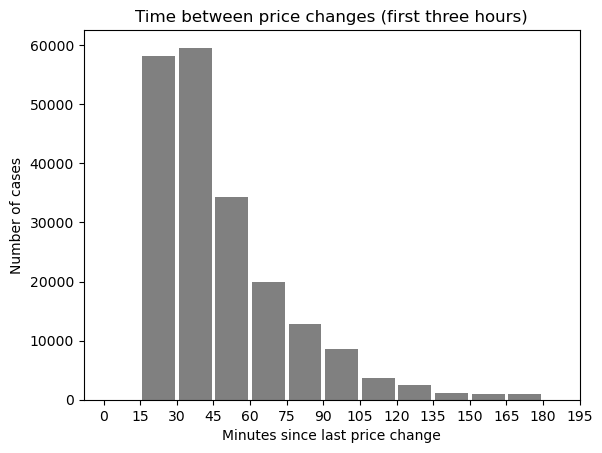

In [26]:
# Time interval between price changes, E10
mask = changes_e10['minutes_since_change'] <= 180

plt.figure()
plt.hist(
    changes_e10.loc[mask, 'minutes_since_change'],
    bins = np.arange(0, 195, 15),
    density=False,
    color='gray',
    rwidth=0.9 
)
plt.title("Time between price changes (first three hours)")
plt.xlabel("Minutes since last price change")
plt.ylabel("Number of cases")
xticks = range(0, 201, 15)
plt.xticks(xticks)
plt.show()

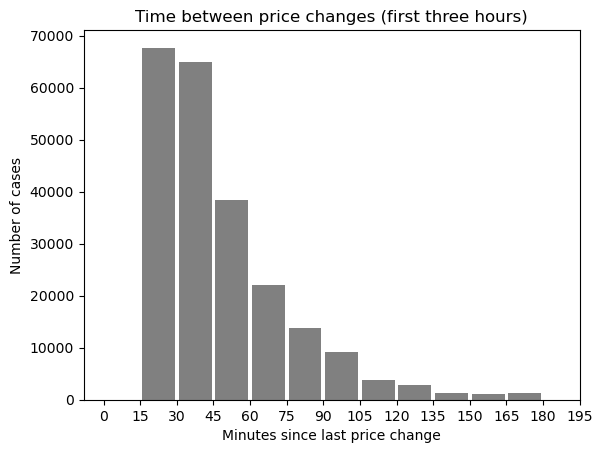

In [27]:
# Time interval between price changes, Diesel
mask = changes_diesel['minutes_since_change'] <= 180

plt.figure()
plt.hist(
    changes_diesel.loc[mask, 'minutes_since_change'],
    bins = np.arange(0, 195, 15),
    density=False,
    color='gray',
    rwidth=0.9 
)
plt.title("Time between price changes (first three hours)")
plt.xlabel("Minutes since last price change")
plt.ylabel("Number of cases")
xticks = range(0, 201, 15)
plt.xticks(xticks)
plt.show()

# 3. Tables

In [16]:
df = df.sort_values(['station_uuid', 'date'])

# Create change indicator columns: 1 if the price changes compared to the previous observation at the same station
df['change_diesel'] = df.groupby('station_uuid')['diesel'].diff().ne(0).astype(int)
df['change_e5']     = df.groupby('station_uuid')['e5'].diff().ne(0).astype(int)
df['change_e10']    = df.groupby('station_uuid')['e10'].diff().ne(0).astype(int)

# Extract only the date part (without time)
df['day'] = df['date'].dt.date

# Sum the number of changes per station and day
daily_changes = df.groupby(['station_uuid', 'day'])[['change_diesel', 'change_e5', 'change_e10']].sum().reset_index()

# Print min, average, and max number of changes per fuel type
for fuel in ['change_diesel', 'change_e5', 'change_e10']:
    print(f"--- {fuel.upper()} ---")
    print('min:', daily_changes[fuel].min())
    print('avg:', daily_changes[fuel].mean())
    print('max:', daily_changes[fuel].max())

# Summary statistics (min, mean, max) for all fuel types
summary = daily_changes[['change_diesel', 'change_e5', 'change_e10']].agg(['min', 'mean', 'max'])
print(summary)

--- CHANGE_DIESEL ---
min: 0
avg: 41.275644746662245
max: 96
--- CHANGE_E5 ---
min: 0
avg: 40.37076042789618
max: 96
--- CHANGE_E10 ---
min: 0
avg: 39.24902562401526
max: 96
      change_diesel  change_e5  change_e10
min        0.000000    0.00000    0.000000
mean      41.275645   40.37076   39.249026
max       96.000000   96.00000   96.000000


In [17]:
# Sort data by station and timestamp
df = df.sort_values(['station_uuid', 'date'])

# Compute price differences compared to previous observation at the same station
df['diff_diesel'] = df.groupby('station_uuid')['diesel'].diff()
df['diff_e5']     = df.groupby('station_uuid')['e5'].diff()
df['diff_e10']    = df.groupby('station_uuid')['e10'].diff()

# Dictionary to store results
results = {}

# Loop over fuel types and calculate statistics for price increases and decreases
for fuel, diff_col in [('diesel', 'diff_diesel'), ('e5', 'diff_e5'), ('e10', 'diff_e10')]:
    decrease = df[df[diff_col] < 0][diff_col]
    increase = df[df[diff_col] > 0][diff_col]
    
    results[fuel] = {
        'decrease_min': decrease.min(),
        'decrease_max': decrease.max(),
        'decrease_avg': decrease.mean(),
        'increase_min': increase.min(),
        'increase_max': increase.max(),
        'increase_avg': increase.mean()
    }

# Display results nicely as DataFrame
df_results = pd.DataFrame(results).T
print(df_results)


        decrease_min  decrease_max  decrease_avg  increase_min  increase_max  \
diesel        -0.230         -0.01     -0.022773          0.01         0.220   
e5            -1.879         -0.01     -0.022451          0.01         1.859   
e10           -1.819         -0.01     -0.022326          0.01         1.799   

        increase_avg  
diesel      0.042748  
e5          0.041455  
e10         0.041056  


In [18]:
# Select only the desired time period (e.g., April 7–13)
start = pd.Timestamp('2025-04-07')
end = pd.Timestamp('2025-04-13 23:59:59')
subset = df[(df['date'] >= start) & (df['date'] <= end)]

# Min, Max, and Average for each fuel type
summary = subset[['diesel', 'e5', 'e10']].agg(['min', 'max', 'mean'])
print(summary)


        diesel       e5       e10
min   1.458000  0.00000  0.000000
max   2.139000  2.29900  2.239000
mean  1.573284  1.67175  1.499489


In [19]:
# All gas station coordinates
coords = df[['latitude', 'longitude']].drop_duplicates().to_numpy()
coords_rad = np.deg2rad(coords)  # BallTree requires radians

# Build BallTree
tree = BallTree(coords_rad, metric='haversine')

# Radii in kilometers (Earth radius ~6371 km)
radii_km = [3, 5, 10]
radii_rad = [r / 6371 for r in radii_km]  # Convert km to radians

neighbor_counts = {}

for r_km, r_rad in zip(radii_km, radii_rad):
    # For each coordinate: number of neighbors within the radius (including itself!)
    ind = tree.query_radius(coords_rad, r=r_rad)
    n_neighbors = np.array([len(x) - 1 for x in ind])  # subtract 1 because a station matches itself
    neighbor_counts[r_km] = {
        'min': n_neighbors.min(),
        'avg': n_neighbors.mean(),
        'max': n_neighbors.max()
    }

# Output
for r in radii_km:
    print(f"{r} km --- min: {neighbor_counts[r]['min']}, avg: {neighbor_counts[r]['avg']:.2f}, max: {neighbor_counts[r]['max']}")


3 km --- min: 0, avg: 2.41, max: 10
5 km --- min: 0, avg: 4.26, max: 22
10 km --- min: 0, avg: 9.65, max: 30
